<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/4_1_DataReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Section 4.1 — Data Reduction

This notebook implements horizontal reduction (feature selection) and vertical reduction (record elimination) for the Chicago Crime 2017 dataset.  
It generates Figures 43–46 and saves them under `/content/drive/MyDrive/Infosys 722/figs/` while also displaying them inline.


In [1]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob
FIG_DIR = "/content/drive/MyDrive/Infosys 722/figs"
TAB_DIR = "/content/drive/MyDrive/Infosys 722/tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
print("Directories ready.")


Mounted at /content/drive
Directories ready.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from IPython.display import display


In [3]:

# Try to load features_district_month (handle both directory and file cases)
path = os.path.join(TAB_DIR, "features_district_month.csv")

if os.path.isdir(path):
    # PySpark output folder case
    csv_files = glob.glob(os.path.join(path, "part-*.csv"))
    if not csv_files:
        raise FileNotFoundError("No part-*.csv found in directory: " + path)
    data_path = csv_files[0]
else:
    # Single file case
    data_path = path

print("Reading from:", data_path)
df = pd.read_csv(data_path)
print("Loaded:", df.shape)
df.head()


Reading from: /content/drive/MyDrive/Infosys 722/tables/features_district_month.csv/part-00000-af532d76-524a-460d-937c-20a3ed3084e2-c000.csv
Loaded: (267, 15)


,District,Month,Total,Arrests,Domestics,NightCnt,ArrestRate,DomesticRate,NightShare,Lag1_Total,Lag3_Total,Roll3_Total,Lag1_Total_imp,Lag3_Total_imp,Roll3_Total_imp
0,NaN,12,1,0,0,0,0.000000,0.000000,0.000000,NaN,NaN,1.000000,NaN,NaN,1.000000
1,1.0,1,1071,194,51,97,0.181139,0.047619,0.090570,NaN,NaN,1071.000000,1271.0,1252.0,1071.000000
2,1.0,2,1018,195,41,81,0.191552,0.040275,0.079568,1071.0,NaN,1044.500000,1071.0,1252.0,1044.500000
3,1.0,3,1186,202,53,104,0.170320,0.044688,0.087690,1018.0,NaN,1091.666667,1018.0,1252.0,1091.666667
4,1.0,4,1201,218,46,112,0.181515,0.038301,0.093256,1186.0,1071.0,1135.000000,1186.0,1071.0,1135.000000


Using candidate columns: ['ArrestRate', 'DomesticRate', 'NightShare', 'Lag1_Total', 'Lag3_Total', 'Roll3_Total']
Saved: /content/drive/MyDrive/Infosys 722/figs/fig43_correlation_heatmap.png


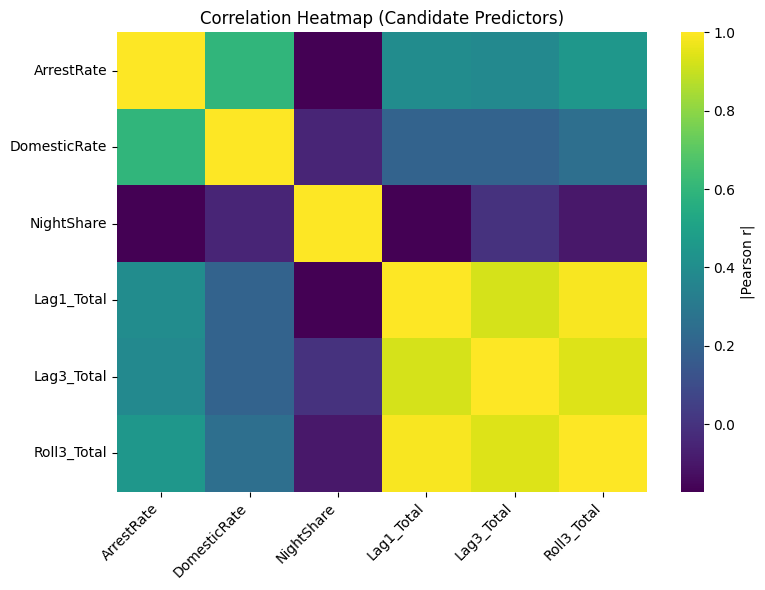

In [9]:
# Candidate features we expect
cand_cols_expected = [
    "District_Month_ArrestRate","District_Month_DomesticRate",
    "NightShare_DistMonth","OutdoorShare_DistMonth",
    "Lag1_Count_DistMonth","Lag3_Count_DistMonth","Roll3Mean_DistMonth",
    "Z_Count_DistMonth"
]

# 只保留 df 里真实存在的列
cand_cols = ["ArrestRate","DomesticRate","NightShare","Lag1_Total","Lag3_Total","Roll3_Total"]
print("Using candidate columns:", cand_cols)


if len(cand_cols) >= 2:
    corr = df[cand_cols].corr(method="pearson")

    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(corr, annot=False, cmap="viridis", cbar_kws={"label":"|Pearson r|"}, ax=ax)
    ax.set_title("Correlation Heatmap (Candidate Predictors)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    fig.tight_layout()

    out_path = os.path.join(FIG_DIR,"fig43_correlation_heatmap.png")
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    display(fig)
    plt.close(fig)
else:
    print("⚠️ Skipped Figure 43: Not enough candidate columns found in df")


Saved: /content/drive/MyDrive/Infosys 722/figs/fig44_permutation_importance.png


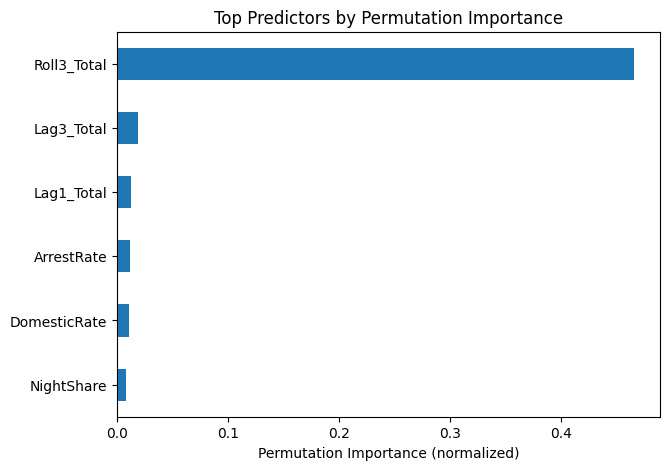

In [10]:
y = (df["Total"] > df["Total"].median()).astype(int)

if cand_cols:   # 只有 cand_cols 非空时才跑
    X = df[cand_cols].fillna(0)

    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X, y)
    perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

    imp = pd.Series(perm.importances_mean, index=cand_cols).sort_values()

    fig, ax = plt.subplots(figsize=(7,5))
    imp.plot.barh(ax=ax)
    ax.set_title("Top Predictors by Permutation Importance")
    ax.set_xlabel("Permutation Importance (normalized)")

    out_path = os.path.join(FIG_DIR,"fig44_permutation_importance.png")
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print("Saved:", out_path)
    display(fig)
    plt.close(fig)
else:
    print("⚠️ Skipped Figure 44: No candidate columns available for feature importance")

    print(df.columns.tolist())



Saved: /content/drive/MyDrive/Infosys 722/figs/fig45_selected_features.png


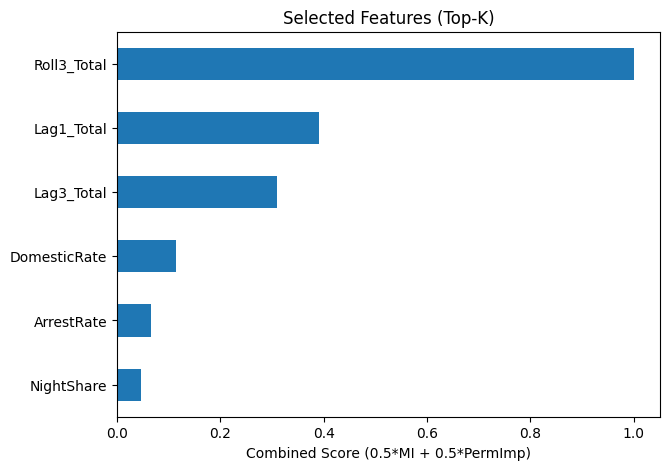

In [11]:

mi = mutual_info_classif(X,y, discrete_features=False, random_state=42)
mi_series = pd.Series(mi, index=cand_cols)

combined = 0.5*(mi_series/mi_series.max()) + 0.5*(imp/imp.max())
combined = combined.sort_values()

fig, ax = plt.subplots(figsize=(7,5))
combined.plot.barh(ax=ax)
ax.set_title("Selected Features (Top-K)")
ax.set_xlabel("Combined Score (0.5*MI + 0.5*PermImp)")

out_path = os.path.join(FIG_DIR,"fig45_selected_features.png")
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print("Saved:", out_path)
display(fig)
plt.close(fig)


In [ ]:

before = len(df)
df_reduced = df.dropna()
after = len(df_reduced)

fig, ax = plt.subplots(figsize=(6,5))
ax.bar(["Before","After"], [before, after], width=0.5)
for i,val in enumerate([before,after]):
    ax.text(i, val+2, f"{val}", ha="center")
ax.set_ylabel("Rows")
ax.set_title("Vertical Reduction of district-month records")

out_path = os.path.join(FIG_DIR,"fig46_vertical_reduction.png")
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print("Saved:", out_path)
display(fig)
plt.close(fig)
